In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [2]:
train_data_1 = pd.read_csv('price_data_tr.csv')
test_data_1 = pd.read_csv('price_data_val.csv')
test_data = pd.read_csv('price_data_ts.csv')

In [3]:
test_data_2 = pd.read_csv('price_data_ts.csv', dtype ='str')

In [4]:
print(train_data_1.shape)
print(test_data.shape)

(12968, 21)
(4322, 21)


In [5]:
print(train_data_1.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

           id             date     price  bedrooms     long  sqft_living15  \
0  1310440590  20150413T000000  440000.0         3 -122.107           2700   
1  1437580480  20140918T000000  994000.0         5 -121.992           4020   
2  7617500075  20140721T000000  427000.0         3 -122.373           1830   
3  8122100130  20140618T000000  415000.0         3 -122.376           1220   

   sqft_lot15  
0        7500  
1        7528  
2        9000  
3        4800  


In [6]:
all_features_1 = pd.concat((train_data_1.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
numeric_features_1 = all_features_1.dtypes[all_features_1.dtypes != 'object'].index
all_features_1[numeric_features_1] = all_features_1[numeric_features_1].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features_1[numeric_features_1] = all_features_1[numeric_features_1].fillna(0)

In [8]:
all_features_1 = pd.get_dummies(all_features_1, dummy_na=True)
all_features_1.shape

(17290, 390)

In [9]:
n_train_1 = train_data_1.shape[0]
n_test_1 = test_data.shape[0]
train_features_1 = tf.constant(all_features_1[:n_train_1].values, dtype=tf.float32)
test_features_1 = tf.constant(all_features_1[n_test_1:].values, dtype=tf.float32)
train_labels_1 = tf.constant(train_data_1.price.values.reshape(-1, 1),dtype=tf.float32)

In [26]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(390, activation='tanh'))
    #net.add(tf.keras.layers.Dropout(0.4))
    net.add(tf.keras.layers.Dense(100, activation='relu'))
    net.add(tf.keras.layers.Dense(25, activation='relu'))
    net.add(tf.keras.layers.Dense(5, activation='relu'))
    net.add(tf.keras.layers.Dense(1))
            
    return net

In [11]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(
        tf.reduce_mean(loss(tf.math.log(y_true), tf.math.log(clipped_preds))))

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size, test_features_1, test_data):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
        if i+1 == 5:
            preds = net(test_features_1).numpy()
            test_data['price'] = pd.Series(preds.reshape(1, -1)[0])
            submission = pd.concat([(test_data['id']+test_data['date']).str.zfill(25), test_data['price']], axis=1)
            submission.to_csv('submission.csv', index=False)
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.541226, valid log rmse 0.542532
fold 2, train log rmse 0.539144, valid log rmse 0.549156
fold 3, train log rmse 0.545131, valid log rmse 0.539970
fold 4, train log rmse 0.541959, valid log rmse 0.548845
fold 5, train log rmse 0.546151, valid log rmse 0.588407
5-fold validation: avg train log rmse: 0.542722, avg valid log rmse: 0.553782


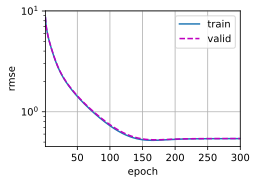

In [27]:
k, num_epochs, lr,weight_decay, batch_size = 5, 300, 10,0, 32
train_l, valid_l = k_fold(k, train_features_1, train_labels_1, num_epochs, lr,weight_decay, batch_size, test_features_1, test_data_2)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')